# Subject data to catatonia prediction 
Data includes: 
    - Bush-Francis pre/post treatment
    - Drugs and doses pre/post treatment for antipsychotic, lamotragine and benzos
* Drug doses are used to calculate target concentration and target occupation.
* Target occupations are coupled to Wilson-Cowan model parameters. 
* Model parameters are optimized for catatonia symptoms.

In [1]:
%matplotlib inline
from IPython.display import display   # To print DataFrames nicely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
root_path = '/home/ec2-user/SageMaker/cascadia-behavioral-healthcare'
sys.path.insert(1, root_path + '/src')
data_path = root_path + '/data' # location of data files

### Transform target occupations to Wilson_Cowan model parameters
Wilson-Cowan description of cortical states generated by excitatory-inhibitory neural pools.
Population of excitatory and inhibitory neurons:
$$\tau_0 \dot{u_0} = -u_0 + f(w_{00}u_0 + w_{01}u_1 + I_0)$$
$$\tau_1 \dot{u_1} = -u_1 + f(w_{10}u_0 + w_{11}u_1 + I_1)$$
where for the E-I circuit, $w_{00}<0$ and $w_{01}<0$.

### Define class to convert clinical dose data to Wilson-Cowan model parameters

In [2]:
clinical_data = pd.read_csv('synth_drug_BF__07212022.csv')
clinical_data.head()

,Unnamed: 0,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
0,0,a,18,6,NaN,NaN,NaN,20.0,3.0,NaN,...,NaN,4.00,800.0,NaN,NaN,500.0,NaN,2.0,NaN,NaN
1,2,c,14,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.00,550.0,NaN,NaN,450.0,NaN,NaN,NaN,NaN
2,7,h,16,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.50,550.0,NaN,NaN,500.0,NaN,NaN,NaN,NaN
3,8,i,22,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.00,250.0,NaN,NaN,400.0,NaN,NaN,NaN,NaN
4,9,j,14,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.75,NaN,NaN,NaN,450.0,NaN,2.0,45.0,NaN


In [3]:
clinical_data['post_Clozapine'].median()

350.0

In [4]:
clinical_mean = clinical_data.describe()
clinical_mean

,Unnamed: 0,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,pre_Fluphenazine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
count,58.000000,58.000000,58.000000,6.0,9.0,0.0,3.0,8.0,0.0,1.0,...,12.000000,38.000000,38.000000,3.0,0.0,58.000000,15.000000,18.0,20.000000,0.0
mean,53.172414,17.275862,4.086207,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.166667,2.427632,456.578947,250.0,NaN,455.172414,2.333333,2.0,37.500000,NaN
std,28.434065,3.919332,2.767509,0.0,0.0,NaN,0.0,0.0,NaN,NaN,...,0.389249,1.242420,225.463802,0.0,NaN,39.391930,0.487950,0.0,11.754059,NaN
min,0.000000,11.000000,0.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.000000,1.000000,200.000000,250.0,NaN,400.000000,2.000000,2.0,20.000000,NaN
25%,30.250000,14.000000,2.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.000000,1.562500,250.000000,250.0,NaN,412.500000,2.000000,2.0,20.000000,NaN
50%,57.000000,17.000000,4.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.000000,1.750000,350.000000,250.0,NaN,450.000000,2.000000,2.0,45.000000,NaN
75%,77.250000,20.000000,6.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.000000,3.500000,550.000000,250.0,NaN,500.000000,3.000000,2.0,45.000000,NaN
max,98.000000,26.000000,13.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,2.000000,6.750000,1050.000000,250.0,NaN,500.000000,3.000000,2.0,45.000000,NaN


In [5]:
from itertools import combinations
# test_drugs = ['post_Clozapine', 'post_Olanzapine', 'post_Lamotrigine', 'post_Clonazepam', 'post_Lorazepam']
test_drugs = ['post_Clozapine', 'post_Lamotrigine', 'post_Clonazepam']
trial_combo = [list(l) for i in range(len(test_drugs)) for l in combinations(test_drugs, i+1)]
num_trials = 1 + len(trial_combo)
num_trials

8

In [8]:
pharma_doses = clinical_data.loc[:1].reindex(list(range(0, num_trials))).reset_index(drop=True)
pharma_doses.loc[:] = np.nan

pharma_doses['pre_Clonazepam'] = np.zeros(len(pharma_doses))
for d in test_drugs:
    pharma_doses[d] = np.zeros(len(pharma_doses))

In [9]:
for m, trial in enumerate(trial_combo):
    for n, d in enumerate(trial):
        pharma_doses.loc[m,d] = clinical_data[d].median()
    
pharma_doses['patient'] = clinical_data.loc[:len(pharma_doses),'patient']
# pharma_doses.head()

In [10]:
import neural_mech.conc_effect as ce     # Custom code for calculating PK effects
# d2m = ce.Dose_Conversion(clinical_data)

# Load clinical data and seperate into pre/post-treatment datasets
data_file_name = 'synth_drug_BF_20_clientDrugs_04132017_L4+.csv'
# pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_path + '/' 
#                                                                      + data_file_name))
# pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_file_name))
pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pharma_doses)

# Instantiate data processing objects for pre & post data
d2a_pre = ce.Dose_Conversion(pre_clinical)
d2a_post = ce.Dose_Conversion(post_clinical)

# Load pharmacokinetic information on relevant drugs
drugParams = pd.read_excel(data_path + '/' + 'drugParams.xls', sheet_name='params')
d2a_pre.load_pharmacokinetic_info(drugParams)
d2a_post.load_pharmacokinetic_info(drugParams)

# Load drug affinity data and calculate target occupancy
pdspDataFile = 'kidb110121.txt'
kidb110121 = pd.read_csv(data_path + '/' + pdspDataFile, 
                                header=None, sep="\t", error_bad_lines=False, 
                                engine='python')
d2a_pre.load_drug_affinities(kidb110121)
d2a_post.load_drug_affinities(kidb110121)

In [11]:
# Calculate Wilson-Cowan parameter values corresponding to doses
model_param_pre = d2a_pre.dose_to_model(p_wt=0.35)
display(model_param_pre.head())

model_param_post = d2a_post.dose_to_model(p_wt=0.35)
display(model_param_post.head())

,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,0.999305,1.000190,1.016077,1.000000,1.000694,0.999810,1.000694
1,1.0,0.999983,1.000032,1.006211,1.000000,1.000017,0.995850,0.995898
2,1.0,1.000000,1.000000,1.000000,1.011552,1.011552,1.000000,1.000000
3,1.0,0.999288,1.000222,1.022572,1.000000,1.000711,0.995662,0.996584
4,1.0,0.999305,1.000190,1.016077,1.011552,1.012269,0.999810,1.000694


Clean dataframe for next step

In [12]:
model_param_post['BF_total'] =  post_clinical['post_total_bf'] 
model_param_post.loc['control','BF_total'] = 0

param_BF = model_param_post
print(param_BF.tail(1).index)
param_BF.drop(param_BF.tail(1).index, inplace=True)
param_BF.reset_index(drop=True, inplace=True)
print (len(param_BF))
param_BF.tail()

Index(['control'], dtype='object')
8


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
3,1.0,0.999288,1.000222,1.022572,1.000000,1.000711,0.995662,0.996584,NaN
4,1.0,0.999305,1.000190,1.016077,1.011552,1.012269,0.999810,1.000694,NaN
5,1.0,0.999983,1.000032,1.006211,1.011552,1.011570,0.995850,0.995898,NaN
6,1.0,0.999288,1.000222,1.022572,1.011552,1.012286,0.995662,0.996584,NaN
7,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN


### Load the neural model generator
Define a function to set the model parameters and compute the fixed points.

0 1.414620543144828
1 1.4721345519714375
2 1.6310066767097018
3 1.1333936802511844
4 1.2850984601937379
5 1.3418338555257963
6 1.0091595509931945
7 1.7696743875687586


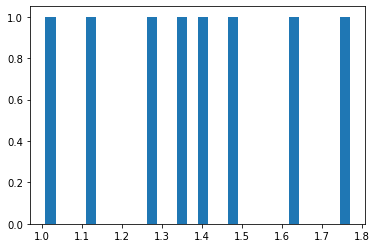

In [13]:
import neural_mech.neural_circuit as ncircuit
nc = ncircuit.Neural_Circuit()

model_pars = ['mu0','mu1','th0','th1','w00', 'w01','w10','w11']
barriers = []
# for index, row in param_BF.loc[:25].iterrows():
for index, row in param_BF.iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
#     print(index, wc.find_fp(pars, 0, 0), wc.find_fp(pars, 0.4, 0.5), wc.find_fp(pars, 1, 0.9))
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
    print(index, barrier)

plt.hist(barriers, bins=30);

,barrier,change,combo,num_combo,Treatment
0,1.769674,0.000000,[],0,None
1,1.631007,0.138668,[post_Clonazepam],1,Clon
2,1.472135,0.297540,[post_Lamotrigine],1,Lamo
3,1.414621,0.355054,[post_Clozapine],1,Cloz
4,1.341834,0.427841,"[post_Lamotrigine, post_Clonazepam]",2,Lamo Clon
5,1.285098,0.484576,"[post_Clozapine, post_Clonazepam]",2,Cloz Clon
6,1.133394,0.636281,"[post_Clozapine, post_Lamotrigine]",2,Cloz Lamo
7,1.009160,0.760515,"[post_Clozapine, post_Lamotrigine, post_Clonaz...",3,Cloz Lamo Clon


<Figure size 576x360 with 0 Axes>

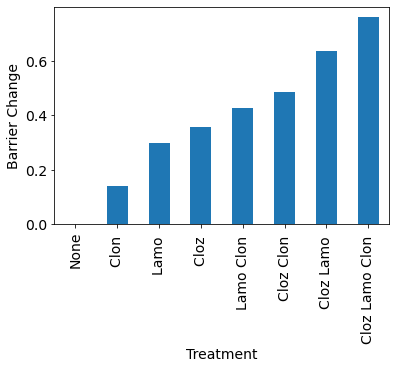

In [16]:
combo_barriers_median = pd.DataFrame({'barrier':barriers, 'change':barriers, 
                                      'combo':trial_combo+[[]], })
combo_barriers_median['change'] = barriers[-1] - combo_barriers_median['change']
combo_barriers_median['num_combo'] = [len(c) for c in combo_barriers_median['combo']]
combo_barriers_median = combo_barriers_median.sort_values('change').reset_index(drop=True)
combo_labels = []
for c in combo_barriers_median['combo']:
    drugs = ''
    for item in c:
        drugs = drugs + (str(item)[5:9]) + ' '
    combo_labels.append(drugs)
combo_barriers_median['Treatment'] = combo_labels
combo_barriers_median.loc[0,'Treatment'] = 'None'
display(combo_barriers_median)

fig = plt.figure(figsize=(8,5))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
ax = combo_barriers_median.plot.bar('Treatment', 'change', legend=None)
plt.ylabel('Barrier Change');
fig = ax.get_figure()
fig.savefig('./figs_publ/combo_barrier.tiff', dpi=300, format="tiff")

<Figure size 576x360 with 0 Axes>

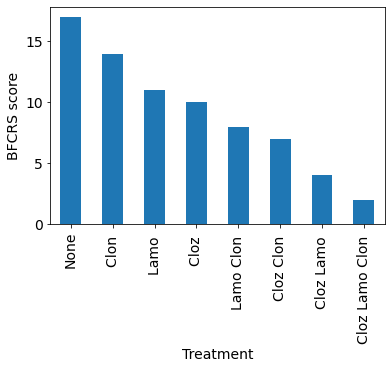

In [18]:
# Convert BF to barrier
#   Numbers from Figure 4

def barrier_to_bf(barrier):
    pre_bf = 20.0
    post_bf = 0.0
    pre_barrier = 1.9
    post_barrier = 0.9
    slope = (post_bf-pre_bf)/(post_barrier-pre_barrier)
    intercept = post_bf - slope*post_barrier
    return slope*barrier + intercept

bf_scores = []
for b in combo_barriers_median['barrier']:
    bf_scores.append(int(barrier_to_bf(b)))
#     print(barrier_to_bf(b))
        
combo_barriers_median['BF'] = bf_scores
# combo_barriers_median.loc[0,'Treatment'] = 'None'
# display(combo_barriers_median)

fig = plt.figure(figsize=(8,5))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
ax = combo_barriers_median.plot.bar('Treatment', 'BF',legend=None)
plt.yticks(range(0, 20, 5))
plt.ylabel('BFCRS score');
fig = ax.get_figure()
fig.savefig('./figs_publ/combo_bf.tiff', dpi=300, format="tiff")